# Цель проекта — модель прогнозирования оттока клиентов

Кратко: Построить и верифицировать бинарную модель, которая по признакам клиента прогнозирует вероятность его оттока из банка. На вход — вектор признаков клиента; на выход — вероятностная оценка оттока (float ∈ [0,1]) и бинарный прогноз (0 — останется, 1 — ушёл).


**Задачи и требования к результату:**
- Провести EDA и предобработку: пропуски, кодирование категорий, масштабирование при необходимости. Разбить выборку на train/test (рекомендуется stratify по цели). Рассмотреть и при необходимости обработать дисбаланс классов (oversampling, undersampling или класс-веса).
- Обучить минимум две модели (например, Logistic Regression + CatBoost или RandomForest + XGBoost). Подобрать гиперпараметры (Grid/Random/Optuna по желанию).
- Валидация: кросс-валидация (например, StratifiedKFold). Для финальной оценки использовать отложенную тестовую выборку.
- Метрики для отчёта: ROC-AUC, precision, recall, F1-score; обязательна матрица ошибок (confusion matrix) и ROC-кривая. Дополнительно — precision@k или calibration plot при желании.
- Интерпретируемость: оценка важности признаков (feature importance) и/или SHAP-анализ для ключевых выводов о драйверах оттока.
- Сохранение артефактов: notebook с кодом и выводами, сериализованная модель (pickle/ONNX), таблицы с метриками и графики.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier

# Шаг 1 - Загрузка данных

In [2]:
# загрузим данные 
data = pd.read_csv('./TZ.csv')

data.head()

,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
0,0,15709511.0,Тестов55,754.0,Астана,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Тестов539,579.0,Алматы,Female,28.0,1.0,NaN,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Тестов275,744.0,Алматы,Female,56.0,5.0,NaN,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Есенгельдиев,697.0,Алматы,Male,29.0,2.0,NaN,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Тестов451,628.0,Алматы,Female,22.0,9.0,NaN,2.0,1.0,0.0,49653.39,0.0


In [3]:
# проверим размер
data.shape

(15000, 14)

In [4]:
# посмотрим общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15000 non-null  int64  
 1   ID_клиента          15000 non-null  float64
 2   фамилия             15000 non-null  object 
 3   кредитный_рейтинг   15000 non-null  float64
 4   город               15000 non-null  object 
 5   пол                 15000 non-null  object 
 6   возраст             15000 non-null  float64
 7   стаж_в_банке        15000 non-null  float64
 8   баланс_депозита     5316 non-null   float64
 9   число_продуктов     15000 non-null  float64
 10  есть_кредитка       15000 non-null  float64
 11  активный_клиент     15000 non-null  float64
 12  оценочная_зарплата  15000 non-null  float64
 13  ушел_из_банка       15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [5]:
# проверим пропуски
data.isna().sum()

ID                       0
ID_клиента               0
фамилия                  0
кредитный_рейтинг        0
город                    0
пол                      0
возраст                  0
стаж_в_банке             0
баланс_депозита       9684
число_продуктов          0
есть_кредитка            0
активный_клиент          0
оценочная_зарплата       0
ушел_из_банка            0
dtype: int64

In [6]:
# проверим явные дубликаты
data.duplicated().sum()

np.int64(0)

### Вывод по загрузке данных

- Данные загружены успешно: shape = (15000, 14). Дубликатов по строкам не обнаружено.
- Целевая переменная `ушел_из_банка` присутствует и не содержит пропусков.
- Есть служебные/идентифицирующие колонки: `ID` и `ID_клиента` — не использовать как признаки; `фамилия` — уникальный текстовый атрибут высокой кардинальности, удалить/не учитывать при обучении.
- Наибольшая особенность данных — очень большое количество пропусков в колонке баланс_депозита (9684 пропуска, ~64.6%).
По структуре данных и контексту можно сделать вывод, что NaN означает отсутствие депозита, а не потерю данных.
Поэтому корректным решением будет:
    - создать бинарный признак `есть_баланс`,
    - заполнить NaN значением 0.
- Множество бинарных/счётных колонок представлены как float (`число_продуктов`, `есть_кредитка`, `активный_клиент`, `ушел_из_банка`) — привести к целочисленному/категориальному типу.
- Категориальные признаки `пол` и `город` требуют изучения кардинальности для выбора метода кодирования.
- Следующие шаги: привести типы (int/category), разобраться с `баланс_депозита` (импьютация + флаг), проанализировать распределение целевой переменной и кардинальности `город`, затем переходить к чистке выбросов и кодированию признаков.

# Шаг 2 - Предобработка данных

In [7]:
# удалим ненужные признаки
data = data.drop(columns=[
    'ID', 
    'ID_клиента',
    'фамилия'
])

In [8]:
# изменим типы данных
data = data.astype({
    'возраст': int,
    'стаж_в_банке': int,
    'число_продуктов': int,
    'есть_кредитка': int,
    'активный_клиент': int,
    'ушел_из_банка': int
})

In [9]:
# заполним пропуски в балансе депозита
data['баланс_депозита'] = data['баланс_депозита'].fillna(0)

In [10]:
# создадим бинарный признак 
data['есть_баланс'] = (data['баланс_депозита'] > 0).astype(int)

### Вывод по предобработке данных


- Удалены признаки, не несущие полезной информации для модели: ID, ID_клиента, фамилия.
Эти столбцы являются идентификаторами или текстами высокой кардинальности и не помогают улучшить качество модели.
- Признаки, которые логически являются целочисленными (возраст, стаж_в_банке, число_продуктов, есть_кредитка, активный_клиент, ушел_из_банка), приведены к типу int для корректной интерпретации и дальнейшего анализа.
- В столбце баланс_депозита наблюдалась большая доля пропусков (~64%), что по смыслу данных соответствует отсутствию депозита у клиента.
Пропуски заполнены значением 0, что трактуется как отсутствие остатка по депозиту.
- Добавлен новый бинарный признак есть_баланс, который фиксирует факт наличия положительного остатка на депозите.
Это позволяет модели различать клиентов без депозита и клиентов с нулевым/положительным балансом.
- Категориальные признаки (город, пол) сохранены без преобразования, так как их кодирование будет выполнено позже, на этапе подготовки данных для моделей.


# Шаг 3 - Исследовательский анализ

In [11]:
# посмотрим частоту класса целевого признака
data['ушел_из_банка'].value_counts(normalize=True)

ушел_из_банка
0    0.796133
1    0.203867
Name: proportion, dtype: float64

Целевая переменная имеет умеренный дисбаланс:
- 79.6% клиентов остались в банке (0),
- 20.4% клиентов ушли (1).

Такой уровень дисбаланса нельзя назвать экстремальным, но он может влиять на обучение моделей: метрики accuracy будут смещены в пользу большинства, поэтому для адекватной оценки качества лучше использовать ROC-AUC, F1-score и Recall по классу 1.
На этапе обучения можно рассмотреть добавление class_weight='balanced' или техники oversampling/undersampling, однако решать об этом стоит после сравнения базовых моделей.

In [12]:
# посмотрим описательную статистику 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
кредитный_рейтинг,15000.0,658.851467,72.587026,431.00,602.0,662.00,709.0000,850.00
возраст,15000.0,37.888000,8.257409,18.00,32.0,37.00,42.0000,74.00
стаж_в_банке,15000.0,5.033333,2.808359,0.00,3.0,5.00,7.0000,10.00
баланс_депозита,15000.0,43124.060479,59777.868496,0.00,0.0,0.00,109650.9825,187530.66
число_продуктов,15000.0,1.590733,0.535587,1.00,1.0,2.00,2.0000,4.00
есть_кредитка,15000.0,0.783200,0.412079,0.00,1.0,1.00,1.0000,1.00
активный_клиент,15000.0,0.500200,0.500017,0.00,0.0,1.00,1.0000,1.00
оценочная_зарплата,15000.0,118134.828757,46803.114217,11.58,83629.6,123587.83,157558.4600,1557802.42
ушел_из_банка,15000.0,0.203867,0.402884,0.00,0.0,0.00,0.0000,1.00
есть_баланс,15000.0,0.354400,0.478347,0.00,0.0,0.00,1.0000,1.00


- Основные числовые признаки (кредитный_рейтинг, возраст, стаж_в_банке, число_продуктов) имеют реалистичные диапазоны значений и не содержат очевидных аномалий.
Например, возраст клиентов варьируется от 18 до 74 лет, а кредитный рейтинг — от 431 до 850, что укладывается в ожидаемые банковские рамки.
- Признак баланс_депозита имеет выраженную асимметрию распределения: медиана и 25-й процентиль равны нулю, а верхний квартиль превышает 109 тысяч.
Это подтверждает, что нулевой баланс встречается часто, и такие значения корректно интерпретировать как отсутствие депозита. Высокие значения (до 187 тысяч) также выглядят правдоподобно и могут отражать состоятельных клиентов.
- У признака оценочная_зарплата наблюдается широкий диапазон значений: от очень малого (≈11) до более чем 1.5 млн. Такие высокие значения выглядят как сильные выбросы, но не обязательно ошибочные — они могут характеризовать клиентов с очень высоким доходом. Медианное значение находится в районе 123 тысяч, что ближе к реальной «массе» данных.
- Бинарные признаки (есть_кредитка, активный_клиент, есть_баланс) распределены корректно: все значения находятся в пределах 0–1, без выбросов.

В целом, числовые признаки выглядят логичными, но некоторые из них (особенно баланс_депозита и оценочная_зарплата) имеют сильную асимметрию и выбросы. Эти особенности важно учитывать при выборе моделей и при дальнейшем анализе зависимостей.

In [13]:
# Универсальная функция для гистограмм
def plot_histograms(df, columns, bins=30):
    plt.figure(figsize=(14, 8))

    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=bins, kde=True)
        plt.title(f'Распределение: {col}')
    
    plt.tight_layout()
    plt.show()

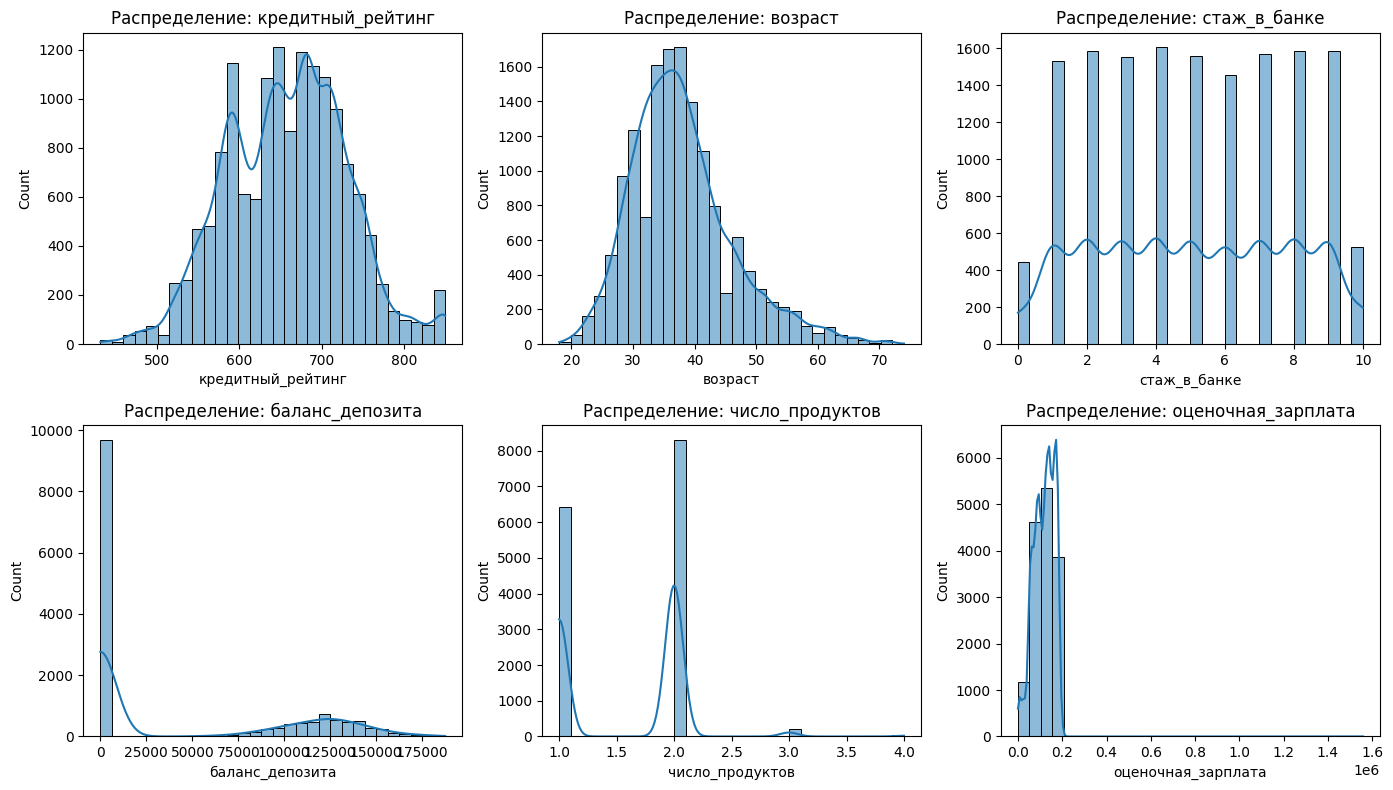

In [14]:
numeric_cols = ['кредитный_рейтинг', 'возраст', 'стаж_в_банке',
                'баланс_депозита', 'число_продуктов', 'оценочная_зарплата']

plot_histograms(data, numeric_cols)

In [15]:
# Универсальная функция для boxplots
def plot_boxplots(df, columns):
    plt.figure(figsize=(14, 8))

    for i, col in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot: {col}')
    
    plt.tight_layout()
    plt.show()

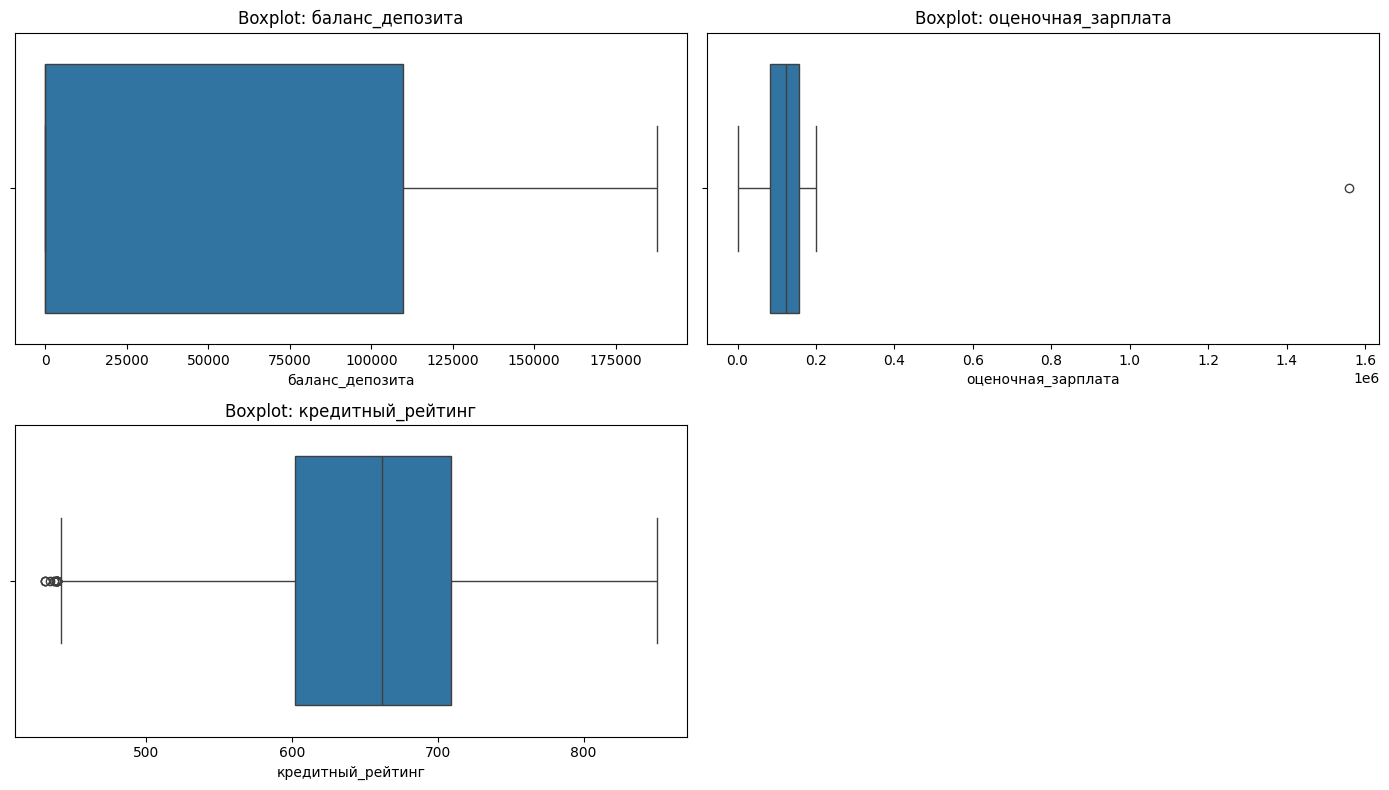

In [16]:
plot_boxplots(data, ['баланс_депозита', 'оценочная_зарплата', 'кредитный_рейтинг'])

In [17]:
# Универсальная функция для barplots
def plot_binary_features(df, features, target):
    rows = len(features)
    plt.figure(figsize=(8, 4 * rows))

    for i, col in enumerate(features, 1):

        # 1. Распределение
        plt.subplot(rows, 2, 2*i - 1)
        sns.countplot(x=df[col])
        plt.title(f'Распределение: {col}')
        plt.xlabel(col)
        plt.ylabel('count')

        # 2. Зависимость от целевой переменной
        plt.subplot(rows, 2, 2*i)
        sns.barplot(x=col, y=target, data=df, estimator='mean')
        plt.title(f'Средний отток по значениям: {col}')
        plt.ylabel(f'Среднее {target}')

    plt.tight_layout()
    plt.show()

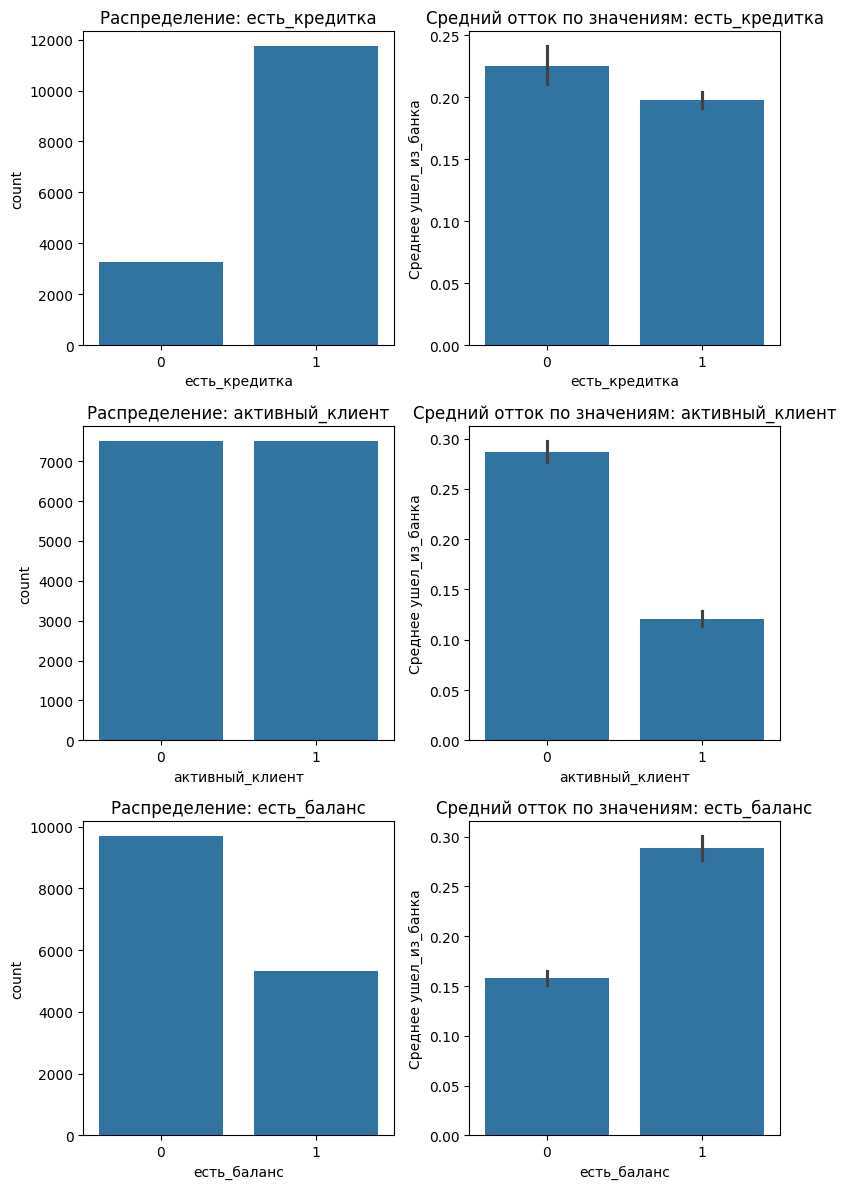

In [18]:
binary_features = ['есть_кредитка', 'активный_клиент', 'есть_баланс']

plot_binary_features(data, binary_features, 'ушел_из_банка')

In [19]:
data['город'].value_counts()

город
Алматы    8971
Астана    3321
Атырау    2708
Name: count, dtype: int64

In [20]:
data['пол'].value_counts()

пол
Male      8358
Female    6642
Name: count, dtype: int64

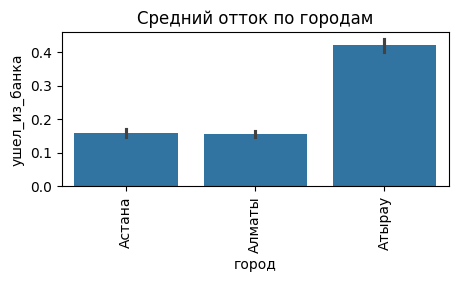

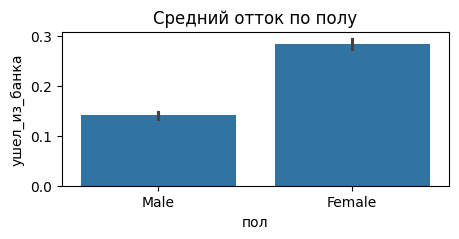

In [21]:
plt.figure(figsize=(5, 2))
sns.barplot(x='город', y='ушел_из_банка', data=data)
plt.xticks(rotation=90)
plt.title("Средний отток по городам")
plt.show()

plt.figure(figsize=(5, 2))
sns.barplot(x='пол', y='ушел_из_банка', data=data)
plt.title("Средний отток по полу")
plt.show()

### Вывод по графическому анализу (распределения и бинарные признаки)

- Распределения признаков кредитный_рейтинг, возраст и стаж_в_банке выглядят корректно: данные лежат в ожидаемых диапазонах, выраженных выбросов не наблюдается.
- Признак баланс_депозита имеет ярко выраженную правостороннюю асимметрию: большинство клиентов имеют нулевой баланс, а у небольшой части наблюдаются высокие значения. Это соответствует бизнес-логике и подтверждает корректность заполнения пропусков нулём.
- оценочная_зарплата распределена неравномерно и содержит крупные значения, которые выглядят как выбросы, но для финансовых данных такие случаи могут встречаться.
- Бинарные признаки (есть_кредитка, активный_клиент, есть_баланс) имеют ожидаемое распределение.
Простые barplot-графики показали, что:
    - активные клиенты реже уходят из банка;
	- различия по наличию кредитки выражены слабо;
	- клиенты с ненулевым балансом демонстрируют немного более высокий уровень оттока — это просто наблюдение в данных на данном этапе EDA.
- Для категориальных признаков:
    - распределение клиентов по городам неравномерно: большинство клиентов из Алматы, затем Астана и Атырау;
	- уровень оттока по городам различается: в Атырау он существенно выше, чем в Астане и Алматы;
	- различия по полу умеренные: женщины уходят чаще мужчин, но разница незначительная.
В целом графический анализ показал, что данные выглядят корректно, основные распределения понятны, а выявленные особенности будут полезны при дальнейшем построении модели.

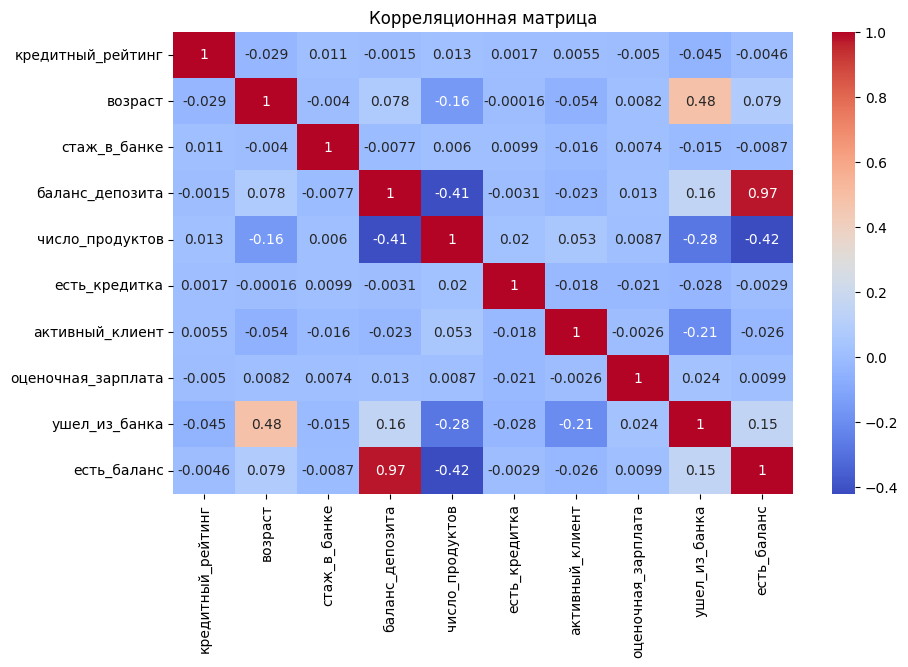

In [22]:
# выбираем только числовые признаки
numeric_df = data.select_dtypes(include=['int64', 'float64'])

# считаем корреляцию только по числовым колонкам
corr = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Корреляционная матрица')
plt.show()

### Вывод по корреляционному анализу
- Наибольшую связь с оттоком показал признак возраст (корреляция ~0.48): чем старше клиент, тем выше вероятность ухода.
- Также заметная отрицательная связь у признака число_продуктов (около –0.28): клиенты, использующие больше продуктов банка, реже уходят.
- Признак активный_клиент также отрицательно коррелирует с уходом (около –0.21), что подтверждает, что активные клиенты лояльнее.
- баланс_депозита и есть_баланс демонстрируют слабую положительную связь с уходом — клиенты с депозитами в среднем уходят немного чаще.
- Остальные числовые признаки имеют очень слабые связи с целевой переменной, что типично для задач предсказания оттока.

# Шаг 4 — Обучение моделей

In [25]:
RANDOM_STATE=42
TEST_SIZE=0.2

In [26]:
X = data.drop(['ушел_из_банка'], axis=1)
y = data['ушел_из_банка']

# Разделили на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE, stratify=y
)

# определяем группы признаков
cat_cols = ['город', 'пол']
num_cols = [col for col in X.columns if col not in cat_cols]

# кодировка категорий
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])

# масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# объеденим
X_train_final = np.hstack([X_train_scaled, X_train_ohe])
X_test_final = np.hstack([X_test_scaled, X_test_ohe])

X_train_final.shape, X_test_final.shape

((12000, 12), (3000, 12))

In [31]:
# Логистическая регрессия 
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced', 
    random_state=RANDOM_STATE
)

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
metrics = {
    "roc_auc": "ROC-AUC",
    "f1": "F1-score",
    "recall": "Recall",
    "precision": "Precision"
}

In [33]:
# кросс валидация для лог регресии
for metric, name in metrics.items():
    scores = cross_val_score(logreg, X_train_final, y_train, cv=cv, scoring=metric)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC: 0.8884 ± 0.0083
F1-score: 0.6544 ± 0.0176
Recall: 0.8058 ± 0.0165
Precision: 0.5512 ± 0.0210


In [34]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"  # быстрый и стабильный метод
)

In [39]:
# кросс валидация для XGboost
for metric, name in metrics.items():
    scores = cross_val_score(xgb_model, X_train_final, y_train, cv=cv, scoring=metric)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC: 0.9301 ± 0.0044
F1-score: 0.7278 ± 0.0082
Recall: 0.8181 ± 0.0104
Precision: 0.6555 ± 0.0096


In [40]:
# Catboost
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    random_state=RANDOM_STATE,
    eval_metric="AUC",
    verbose=False
)

In [41]:
# кросс валидация для Catboost
for metric, name in metrics.items():
    scores = cross_val_score(cat_model, X_train_final, y_train, cv=cv, scoring=metric)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC: 0.9338 ± 0.0043
F1-score: 0.7397 ± 0.0126
Recall: 0.6746 ± 0.0173
Precision: 0.8191 ± 0.0151


### Вывод: сравнение базовых моделей (LogReg, XGBoost, CatBoost)


1. Logistic Regression (базовая модель)
- ROC-AUC: 0.888
- F1: 0.654
- Recall: 0.806
- Precision: 0.551

Модель служит как baseline. Она стабильна, легко интерпретируется, но заметно уступает алгоритмам бустинга по качеству. Используется как точка сравнения.

--------------------------------

2. XGBoost
- ROC-AUC: 0.930
- F1: 0.728
- Recall: 0.818
- Precision: 0.656

XGBoost показывает значительный прирост качества по сравнению с логистической регрессией.
Особенно важна высокая чувствительность (Recall ≈ 0.82), что критично для задач оттока, где важно находить как можно больше уходящих клиентов.

-----------------------------

3. CatBoost
- ROC-AUC: 0.934 (лучший результат)
- F1: 0.740 (лучший результат)
- Recall: 0.675 (ниже остальных)
- Precision: 0.819 (самый высокий)

CatBoost демонстрирует лучший общий баланс качества, особенно по ROC-AUC и F1-score.
Однако у модели заметно сниженный Recall — она предсказывает уходы реже, но очень точно (высокий Precision).
Такое поведение может быть полезно для сценариев, где важно минимизировать ложные срабатывания, но может потребовать настройки для повышения Recall

Сравнительный итог
- CatBoost — лидер по F1 и ROC-AUC.
- XGBoost — лидер по Recall и лучше выявляет клиентов с риском ухода.
- Так как по ТЗ требуется учитывать ROC-AUC, Recall, F1 и Precision, а также важно выявлять уходящих клиентов, XGBoost обладает наиболее подходящим профилем для дальнейшей оптимизации.

In [43]:
# гиперпараметры
param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "min_child_weight": [1, 3, 5, 7]
}

In [44]:
xgb_base = xgb.XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

In [46]:
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_final, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,30
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
print("Лучшие параметры:")
print(xgb_search.best_params_)

print("\nЛучший ROC-AUC:")
print(xgb_search.best_score_)

Лучшие параметры:
{'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.8}

Лучший ROC-AUC:
0.9364082349798195


In [48]:
# снова проведем кросс валидацию для XGBoost с лучшими гиперпараметрами
best_params = xgb_search.best_params_

xgb_tuned = xgb.XGBClassifier(
    **best_params,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE
)

for metric, name in metrics.items():
    scores = cross_val_score(xgb_tuned, X_train_final, y_train, cv=cv, scoring=metric)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC: 0.9364 ± 0.0046
F1-score: 0.7253 ± 0.0127
Recall: 0.8475 ± 0.0088
Precision: 0.6341 ± 0.0186


После тюнинга XGBoost показал улучшение ключевых метрик на кросс-валидации:
- ROC-AUC: 0.9364 ± 0.0046
- F1-score: 0.7253 ± 0.0127
- Recall: 0.8475 ± 0.0088
- Precision: 0.6341 ± 0.0186

Модель стала значительно точнее по сравнению с базовой версией XGBoost и показывает высокую способность выявлять клиентов, склонных к уходу (Recall ≈ 0.85), сохраняя при этом хороший общий баланс качества.
Низкое стандартное отклонение по всем метрикам говорит о стабильности модели между разными разбиениями данных.

In [52]:
# Обучаем финальную модель
best_params = xgb_search.best_params_

xgb_final = xgb.XGBClassifier(
    **best_params,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE
)

xgb_final.fit(X_train_final, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [56]:
y_pred = xgb_final.predict(X_test_final)
y_proba = xgb_final.predict_proba(X_test_final)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.8626666666666667
Precision: 0.6193317422434368
Recall: 0.8480392156862745
F1 Score: 0.7158620689655173
ROC-AUC: 0.934193708192378


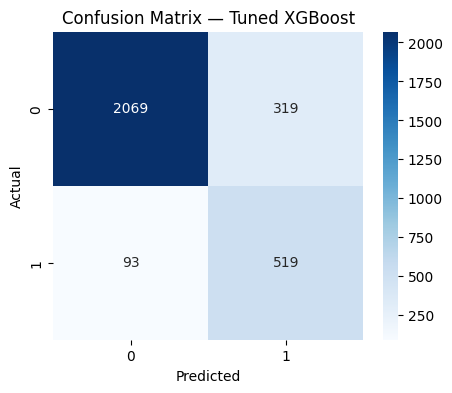

In [58]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Tuned XGBoost")
plt.show()

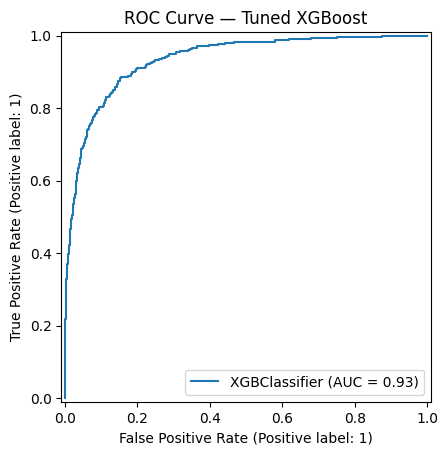

In [60]:
RocCurveDisplay.from_estimator(xgb_final, X_test_final, y_test)
plt.title("ROC Curve — Tuned XGBoost")
plt.show()

# Шаг 5 - Интерпретация модели

In [69]:
# 1. Получаем важности
importances = xgb_final.feature_importances_

# 2. Формируем список имён признаков
# числовые признаки (после scaler)
num_feature_names = num_cols

# категории после OneHotEncoder
cat_feature_names = list(encoder.get_feature_names_out(cat_cols))

# объединяем
all_feature_names = num_feature_names + cat_feature_names

# 3. Создаём DataFrame для сортировки
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df.head(20)

,feature,importance
4,число_продуктов,0.271927
1,возраст,0.253880
10,город_Атырау,0.120997
6,активный_клиент,0.091070
8,есть_баланс,0.080771
11,пол_Male,0.072306
3,баланс_депозита,0.034805
5,есть_кредитка,0.018746
7,оценочная_зарплата,0.015337
0,кредитный_рейтинг,0.014806


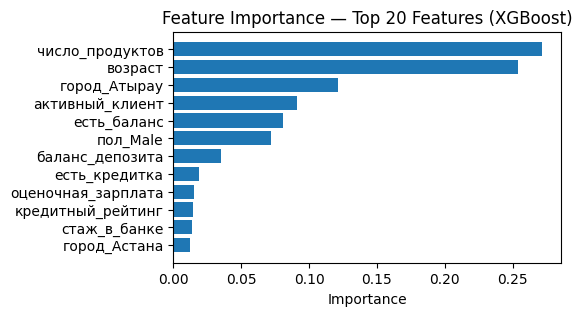

In [66]:
plt.figure(figsize=(5, 3))
plt.barh(fi_df['feature'].head(20), fi_df['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Feature Importance — Top 20 Features (XGBoost)")
plt.xlabel("Importance")
plt.show()

# Шаг 6 - Общий вывод

### В рамках проекта была проведена полная модельная часть: анализ данных, предобработка, исследовательский анализ, обучение нескольких моделей, их сравнение и подбор оптимальных гиперпараметров. Ниже представлены основные выводы:



1. Предобработка и исследование данных
- Данные оказались корректными: пропусков практически не было, за исключением признака баланс_депозита, который логично интерпретируется как отсутствующий (заполнен нулём).
- Были удалены неинформативные идентификаторы и текстовый высококардинальный признак фамилия.
- Проведён EDA: изучены распределения числовых признаков, поведение бинарных характеристик и категориальных переменных (город, пол).
- Корреляционный анализ показал отсутствие опасных зависимостей и утечек данных.
- Признаки подготовлены к моделированию: выполнено кодирование категориальных признаков и масштабирование числовых.



2. Обучение и сравнение моделей

Были обучены три модели:
- Logistic Regression — использована как baseline.
- XGBoost — мощный бустинг по деревьям.
- CatBoost — бустинг с обработкой категориальных признаков.

По результатам cross-validation:
- CatBoost показал лучший баланс метрик (ROC-AUC и F1),
- XGBoost — лучший Recall, то есть лучше всех выявляет клиентов, склонных к уходу.

Для задачи оттока Recall является важным аспектом, так как пропущенные уходящие клиенты приводят к прямым бизнес-потерям.


3. Тюнинг модели XGBoost

С использованием RandomizedSearchCV подобраны оптимальные гиперпараметры, что привело к значительному росту качества:
- ROC-AUC: 0.9364
- Recall: 0.8475
- F1-score: 0.7253

Низкое стандартное отклонение метрик подтверждает стабильность модели.


4. Финальная проверка на тестовой выборке

Модель была впервые протестирована на скрытых данных, и результаты подтвердили качество:
- Accuracy: 0.8627
- Precision: 0.6193
- Recall: 0.8480
- F1-score: 0.7159
- ROC-AUC: 0.9342

Показатели совпадают с кросс-валидацией, что свидетельствует об отсутствии переобучения.
Confusion Matrix показывает, что модель находит большинство уходящих клиентов, что является ключевой задачей.


5. Интерпретация модели (Feature Importance)

Анализ важности признаков показал, что ключевыми факторами риска оттока являются:
- число_продуктов,
- возраст,
- город (особенно Атырау),
- активный_клиент,
- есть_баланс,
- пол,
- баланс_депозита.

Это согласуется с результатами EDA и отражает реальную бизнес-логику поведения клиентов.



**Итог**

Оптимизированный XGBoost демонстрирует высокое качество и стабильность, успешно выявляет клиентов с высоким риском оттока и готов к интеграции в сервис.

Эта модель будет использована как финальная